# Analyse integration evalaluation results
Compared are:
- Different ambient correction methods: top ambient genes removal ("ambientMasked" for the shorter ambient genes list or "ambientMaskedExtended" for the longer list) and different ambient correction tools followed by top ambient removal. Ambient correction tools: DecontX with default learnt corection parameters or more strong amibent removal (termed "fixed"); SoupX wit default correction strength or with increased correction strength (indicated by "rhoadd" - higher number means larger correction). 
- Different integration methods: scVI, scArches.
- scArches with default learning protocol (termed "quick") or protocol with slower learning (termed "slow")
- Multiple re-runs of the same setting to estimate variability across multiple integration runs (denoted by a number from 0 to 2 at the end of the run name).

For integration of all cell types we computed evaluation on cell-type annotated cells (annotated for the ref datasets) - all cell types or beta cells only (evaluation of bio preservation and batch correction) or on all cells (including those without cell type annotation; computed only a subset of metrics that could be computed without cell type annotation). For beta cell integration we computed batch metrics on all cells and bio metrics on cell-type annotated cells onnly.


In [1]:
import pandas as pd
import glob
import os
import pickle
import numpy as np

import matplotlib.pylab as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from  matplotlib.patches import  Patch
import seaborn as sb

from sklearn.preprocessing import minmax_scale

In [2]:
# Path to run results
runs_path='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
BIO=['graph_cLISI', 'NMI', 'ARI', 'ASW_cell_type', 'isolated_label_F1', 'isolated_label_ASW','moransi_conservation'] 
BATCH=['PC_regression', 'ASW_batch', 'kBET', 'kBET_study','graph_connectivity', 'graph_iLISI']

For initial evaluation we computed kBET both on sample (kBET, as other metrics) and study (kBET_study) as batch. However, for computation of merics summaries in paper we only used the one using sample as batch.

## Integration of all cell types

In [5]:
# Get all evaluation metric results 
run_dirs=[
          ('combined/scArches/integrate_combine_individual/run_scArches1603792372.695119/','scArches;ambientMasked;quick;0'),
          ('combined/scArches/integrate_combine_individual/run_scArches1649916019.148133/','scArches;ambientMasked;quick;1'),
          ('combined/scArches/integrate_combine_individual/run_scArches1650008190.874977/','scArches;ambientMasked;quick;2'),
          ('combined/scArches/integrate_combine_individual/run_scArches1605997831.626417/','scArches;ambientMasked;slow;0'),
          ('combined/scArches/integrate_combine_individual/run_scArches1605997831.626664/','scArches;ambientMasked;slow;1'),
          ('combined/scArches/integrate_combine_individual/run_scArches1606480383.88613/','scArches;ambientMasked;slow;2'),
          ('combined/scArches/integrate_combine_individual/run_scArches1605798604.647761/','scArches;ambientMaskedExtended;slow;0'),
          ('combined/scArches/integrate_combine_individual/run_scArches1606061035.453162/','scArches;ambientMaskedExtended;slow;1'),
          ('combined/scArches/integrate_combine_individual/run_scArches1606061035.453407/','scArches;ambientMaskedExtended;slow;2'),
          ('combined/scArches/integrate_combine_individual/run_scArches1603881821.939477/','scArches;ambientMasked+decontX;slow'),
          ('combined/scArches/integrate_combine_individual/run_scArches1604502149.078628/','scArches;ambientMasked+decontX_fixed;slow'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612129003.819243/','scArches;ambientMasked+SoupX_rhoadd0;slow'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612129003.818745/','scArches;ambientMasked+SoupX_rhoadd005;slow'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612129003.818814/','scArches;ambientMasked+SoupX_rhoadd01;slow'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612217039.745045/','scArches;ambientMasked+SoupX_rhoadd0;quick;0'),
          ('combined/scArches/integrate_combine_individual/run_scArches1649794207.047576/','scArches;ambientMasked+SoupX_rhoadd0;quick;1'),
          ('combined/scArches/integrate_combine_individual/run_scArches1649618335.163001/','scArches;ambientMasked+SoupX_rhoadd0;quick;2'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612217039.744893/','scArches;ambientMasked+SoupX_rhoadd005;quick'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612217039.744912/','scArches;ambientMasked+SoupX_rhoadd01;quick'),
          ('combined/scVI/runs/1603814626.572086_SB0/','scVI;ambientMasked'),
          ('combined/scVI/runs/1603814626.761494_SB0/','scVI;ambientMasked+decontX'),
          ('combined/scVI/runs/1604500510.973771_SB0/','scVI;ambientMasked+decontX_fixed'),
          ('combined/scVI/runs/1612129492.366433_SB0/','scVI;ambientMasked+SoupX_rhoadd0'),
          ('combined/scVI/runs/1612129479.815399_SB0/','scVI;ambientMasked+SoupX_rhoadd005'),
          ('combined/scVI/runs/1612129526.764645_SB0/','scVI;ambientMasked+SoupX_rhoadd01')
         ]
    
    

In [6]:
# Store metrics results and corresponding parameters in df
res_df=[]
index=[]
cell_subsets=[('integration_metrics.pkl','all'),('integration_metrics_beta.pkl','beta'),
             ('integration_metrics_allCells.pkl','all_allCells')]
for run_dir, run_name in run_dirs:
    for file, subset in cell_subsets:
        if os.path.isfile(runs_path+run_dir+file):
            run_metrics=pickle.load( open(  runs_path+run_dir+file, "rb" ) )
            run_metrics['subset']=subset
            res_df.append(run_metrics)
            index.append(run_name)
res_df=pd.DataFrame(res_df)
res_df.index=index

In [7]:
# Sort runs for plotting
run_datas=[]
for run_name in res_df.index.unique():
    run_datas.append({'run':run_name,
                      'method':run_name.split(';')[0],
                      'ambient_corr':run_name.split(';')[1]
                         })
run_datas=pd.DataFrame(run_datas)
run_datas.sort_values(['method','ambient_corr'],inplace=True)
res_df=res_df.loc[run_datas['run'],:]

In [8]:
res_df.sort_values('subset')

,PC_regression,ASW_batch,kBET,graph_connectivity,graph_iLISI,graph_cLISI,NMI,ARI,ASW_cell_type,isolated_label_F1,isolated_label_ASW,moransi_conservation,subset,kBET_study,moransi_conservation_study
scArches;ambientMasked;quick;0,0.735321,0.878917,0.526601,0.870861,0.161523,1.000000,0.777187,0.898198,0.514796,0.027968,0.575402,0.663903,all,NaN,NaN
scArches;ambientMasked+SoupX_rhoadd01;quick,0.763201,0.875780,0.479755,0.871352,0.162872,1.000000,0.880473,0.963662,0.527126,0.035316,0.570284,0.663615,all,NaN,NaN
scArches;ambientMasked+SoupX_rhoadd005;quick,0.762264,0.877990,0.480778,0.849182,0.182131,1.000000,0.803877,0.908710,0.514177,0.043346,0.569390,0.662975,all,NaN,NaN
scArches;ambientMasked+decontX;slow,0.706039,0.863196,0.506079,0.880762,0.165755,1.000000,0.881978,0.964698,0.534521,0.052414,0.564359,0.661700,all,NaN,NaN
scArches;ambientMasked+SoupX_rhoadd005;slow,0.696422,0.872936,0.483123,0.867663,0.156544,1.000000,0.880025,0.963577,0.516796,0.043552,0.562973,0.663364,all,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scArches;ambientMasked+SoupX_rhoadd0;quick;0,0.754584,0.921052,0.452779,0.525702,0.190727,0.963251,0.289438,0.172985,0.470222,0.088027,0.578979,0.547646,beta,NaN,NaN
scArches;ambientMasked+SoupX_rhoadd0;quick;2,0.727775,0.923462,0.414348,0.493539,0.179965,0.963338,0.307979,0.254295,0.468918,0.074263,0.574156,0.547995,beta,NaN,NaN
scArches;ambientMaskedExtended;slow;0,0.675950,0.929145,0.381550,0.487370,0.176959,0.957473,0.210546,0.085353,0.465415,0.080563,0.565475,0.547088,beta,NaN,NaN
scArches;ambientMasked+decontX_fixed;slow,0.632026,0.912620,0.390016,0.517742,0.153512,0.965334,0.295289,0.169055,0.463590,0.074950,0.577478,0.549429,beta,NaN,NaN


In [9]:
def dotplot(res_df,h=None,w=None,h_scale=0.7,w_scale=0.6,margins=(0.1,0.03),color='rank'):
    """
    Plot scores as dotplot, separately for bio and batch. Keep only metrics that are not na in any sample.
    :param res_df: Results df to use.
    :param color: "rank" - color by rank or "normalised" - color by score normalised to [0,l]
    """
    # Keep metric that are present and not na in any sample 
    # and that are correctly scaled between 0 and 1 - the latter check is no longer needed 
    # as since metrics have been corrected
    bio=[metric for metric in BIO if metric in res_df.columns and 
         not res_df[metric].isna().any() 
         and (res_df[metric]>=0).all() and (res_df[metric]<=1).all()]
    batch=[metric for metric in BATCH if metric in res_df.columns and 
           not res_df[metric].isna().any()
          and (res_df[metric]>=0).all() and (res_df[metric]<=1).all()]
    # Vstack columns for plotting
    res_df_stacked= res_df[bio+batch].copy()
    res_df_stacked= res_df_stacked.stack().reset_index()
    res_df_stacked.columns=['run','metric','score']
    res_df_stacked['sqrt_score']=np.sqrt(res_df_stacked['score'])

    # Rank  runs in individual metrics
    res_df_stacked['rank']=res_df[bio+batch].rank(axis=0,ascending=True).stack().values # Give larger number (rank) to higher (better) value
    # Normalised scores
    res_df_stacked['normalised']=pd.DataFrame(minmax_scale(res_df[bio+batch]),
                                                    index=res_df.index,columns=bio+batch
                                             ).stack().values
    
    # Plot dotplot
    if h is None:
        h=res_df.shape[0]*h_scale
    if w is None:
        w=len(bio+batch)*w_scale
    rcParams['figure.figsize']= (w,h)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    data_bio=res_df_stacked.query('metric in @bio')
    data_batch=res_df_stacked.query('metric in @batch')
    g=sb.scatterplot(x='metric',y='run',data=data_bio,
                     hue=color,size='sqrt_score',
                     legend=False,
                     sizes=(data_bio['sqrt_score'].min()*(600-80)+80, 
                        data_bio['sqrt_score'].max()*(600-80)+80), 
                     palette='viridis', ax=ax1)
    ax1.margins(*margins)
    ax1.set_xlabel('bio')
    g=sb.scatterplot(x='metric',y='run',data=data_batch,hue=color,size='sqrt_score',
                     legend=False,
                     sizes=(data_batch['sqrt_score'].min()*(600-80)+80, 
                            data_batch['sqrt_score'].max()*(600-80)+80),
                     palette='viridis',ax=ax2)
    ax2.margins(*margins)
    ax2.set_xlabel('batch')
    a=fig.autofmt_xdate(rotation=90 )

In the dotplots the color indicates scaled score across runs (yelow - better, violet - worse) and the size the non-scaled score value.

#### Scores computed on all annotated cells

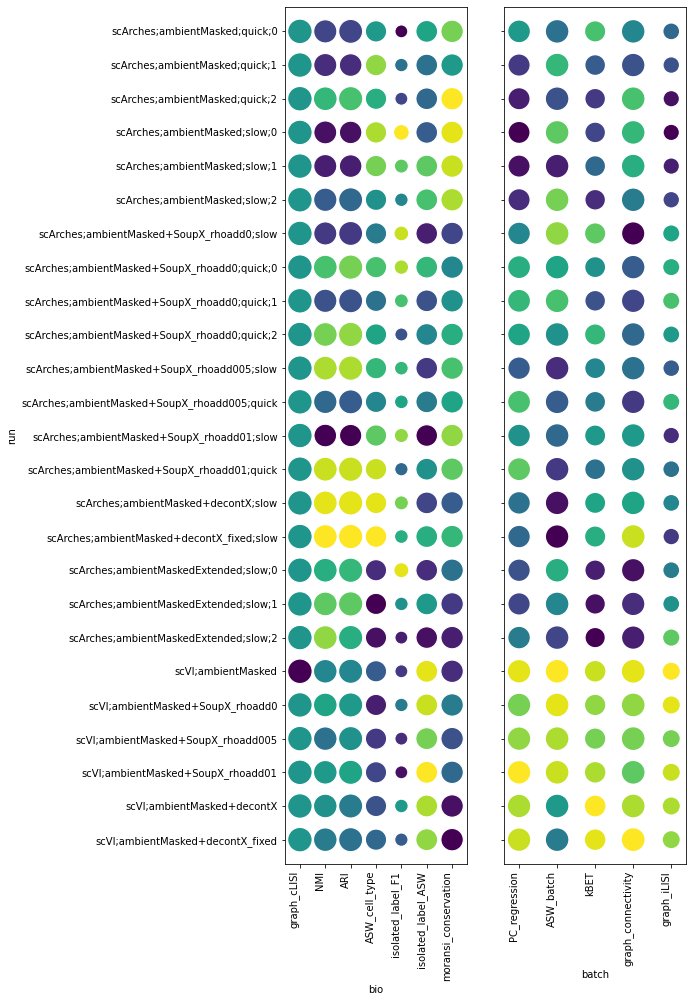

In [10]:
dotplot(res_df.query('subset == "all"'))

#### Scores computed on cells annotated as beta cells

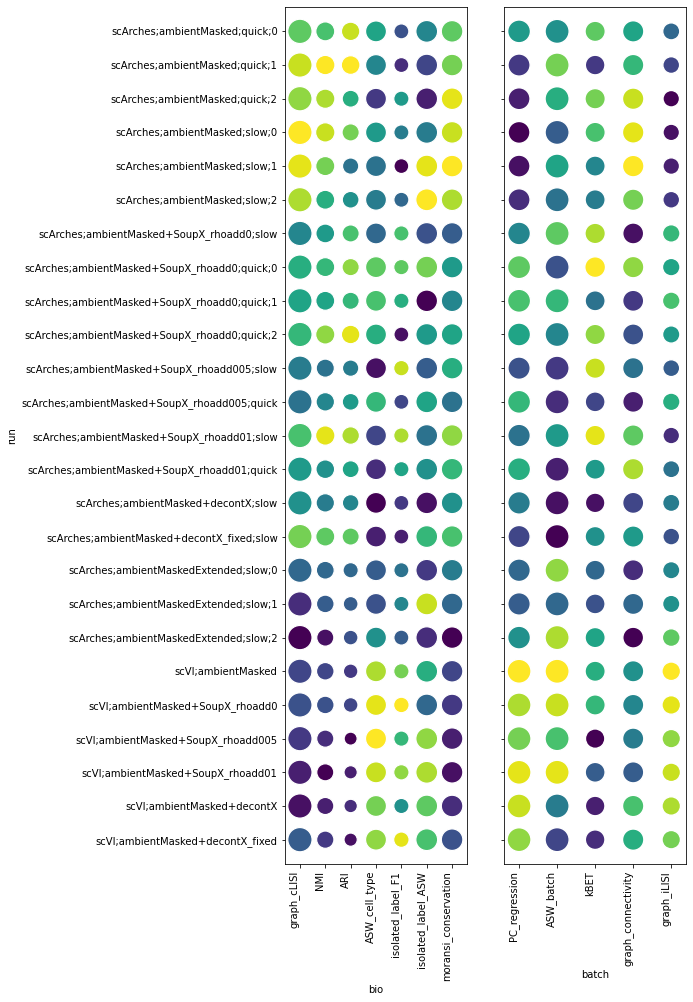

In [11]:
dotplot(res_df.query('subset == "beta"'))

#### Scores computed on all cells 
Regardless of having the annotation or not and what the annotation was. Some metrics could not be computed due tto lack of cell type annotation. For some metrics (e.g. batch) we used clusters instead of cell types for computation.

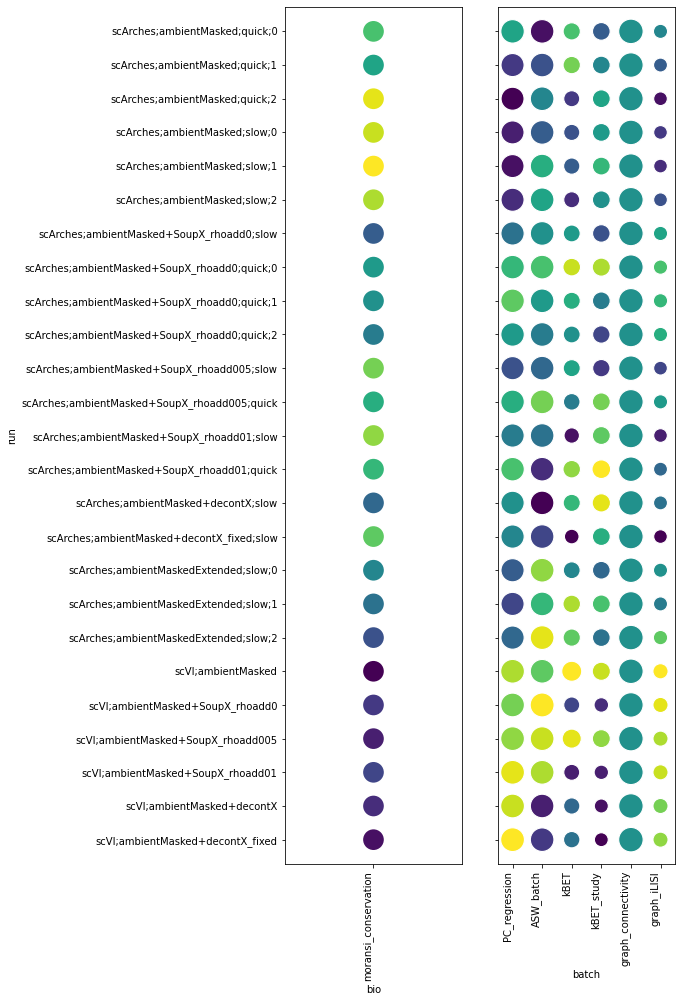

In [12]:
dotplot(res_df.query('subset == "all_allCells"'),w=7)

### Rank based on overall score
Compute rank as in scBI: 0.6 * bio + 0.4 * batch. Excluder kBET_study from computation of scores as this metric does not have the same batch variable as other metrics (study instead of sample; there is a kBET also computed on sample).

In [14]:
def rank(res_df,sort:bool=True,ignore:list=['kBET_study'],return_df=False,plot=True):
    """
    Compute average bio and batch score and their weighted mean. 
    Use only metrics that are not NA in any of the samples.
    Plot as heatmap.
    :param res_df: Results df to use.
    :param ignore: metrics to ignore
    """
    # Scale metrics to be on same scale [0,1]
    bio=[metric for metric in BIO 
         if metric in res_df.columns and not res_df[metric].isna().any() 
         and (res_df[metric]>=0).all() and (res_df[metric]<=1).all()
         and metric not in ignore]
    batch=[metric for metric in BATCH 
           if metric in res_df.columns and not res_df[metric].isna().any() 
           and (res_df[metric]>=0).all() and (res_df[metric]<=1).all()
           and metric not in ignore]
    res_df_scaled=pd.DataFrame(minmax_scale(res_df[bio+batch]),index=res_df.index,columns=bio+batch)
    # Average scores
    mean_bio=res_df_scaled[bio].mean(axis=1)
    mean_batch=res_df_scaled[batch].mean(axis=1)
    mean_score=(mean_bio*0.6 + mean_batch*0.4)
    mean_score=pd.DataFrame([mean_bio,mean_batch,mean_score],index=['bio','batch','overall']).T
    # Plot heatmap of summarized scores
    if sort:
        sort_by='overall'
        if len(bio) ==0 and len(batch)==0:
            raise ValueError("Neither bio or batch were computed - can't sort")
        elif len(bio)==0:
            sort_by='batch'
        elif len(batch)==0:
            sort_by='bio'
        mean_score=mean_score.sort_values(sort_by,ascending=False)
    if plot:
        rcParams['figure.figsize']= (5,res_df.shape[0]*0.4)
        sb.heatmap(mean_score, vmin=0, vmax=1)
    if return_df:
        return mean_score

Ranking based on scores of annotated cells

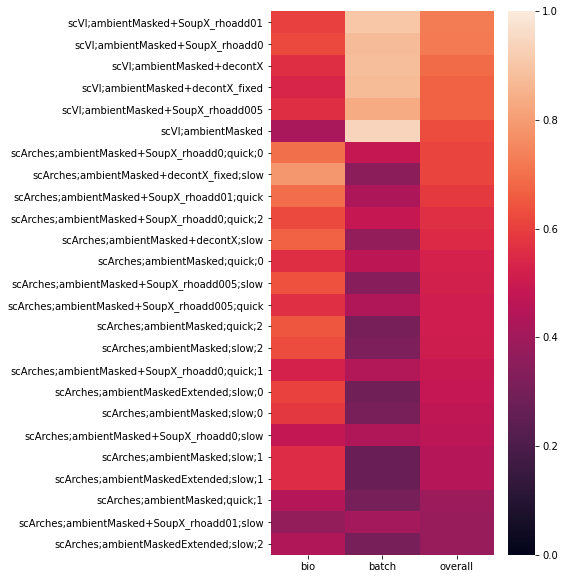

In [15]:
rank_all=rank(res_df.query('subset == "all"'),return_df=True)

In [16]:
rank_all['method']=[idx.split(';')[0] for idx in rank_all.index]
rank_all['ambient']=[idx.split(';')[1] for idx in rank_all.index]
rank_all['lr']=[idx.split(';')[2] if len(idx.split(';'))>=3 else 'NA' for idx in rank_all.index]

Text(0.5, 0.98, 'ref annotated cells')

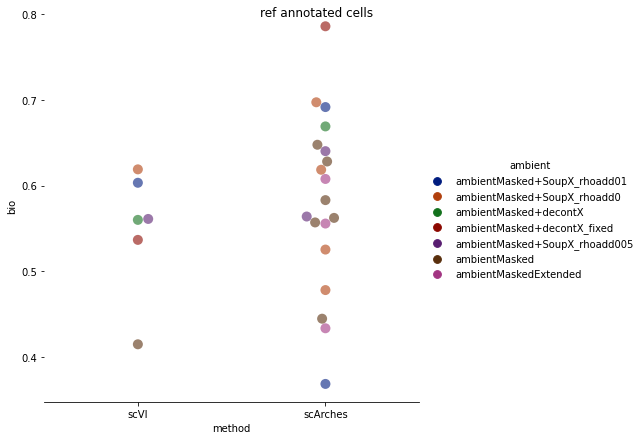

In [17]:
methods=['scVI','scArches']
g = sb.catplot(
    data=rank_all.query('method in @methods'), 
    x="method", y="bio", hue="ambient",palette="dark", alpha=.6, height=6,s=10,
    kind='swarm'
)
g.despine(left=True)
g.set_axis_labels("method", "bio")
g.fig.suptitle('ref annotated cells')

Text(0.5, 0.98, 'ref annotated cells')

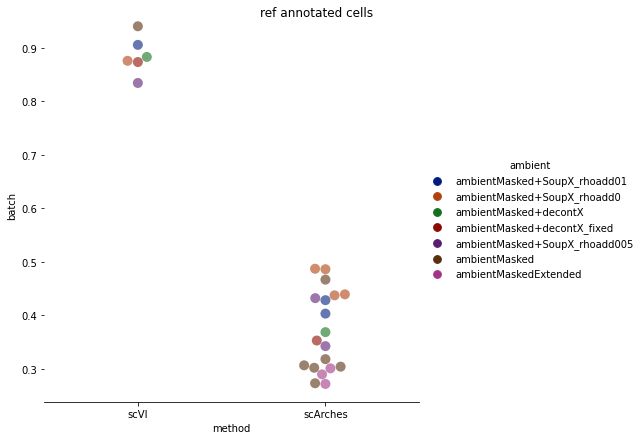

In [18]:
methods=['scVI','scArches']
g = sb.catplot(
    data=rank_all.query('method in @methods'), 
    x="method", y="batch", hue="ambient", palette="dark", alpha=.6, height=6,s=10,
    kind='swarm'
)
g.despine(left=True)
g.set_axis_labels("method", "batch")
g.fig.suptitle('ref annotated cells')

Ranking based on scores computed on cell annotated as beta cells

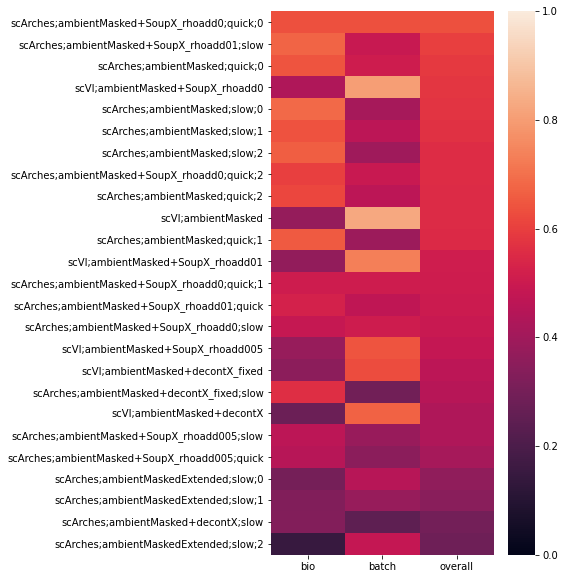

In [19]:
rank_beta=rank(res_df.query('subset == "beta"'),return_df=True)

In [20]:
rank_beta['method']=[idx.split(';')[0] for idx in rank_beta.index]
rank_beta['ambient']=[idx.split(';')[1] for idx in rank_beta.index]

Text(0.5, 0.98, 'ref annotated beta cells')

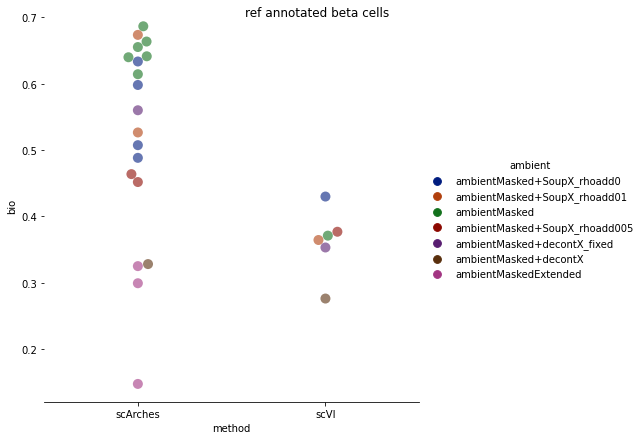

In [21]:
methods=['scVI','scArches']
g = sb.catplot(
    data=rank_beta.query('method in @methods'), 
    x="method", y="bio", hue="ambient", palette="dark", alpha=.6, height=6,s=10,
    kind='swarm'
)
g.despine(left=True)
g.set_axis_labels("method", "bio")
g.fig.suptitle('ref annotated beta cells')

Text(0.5, 0.98, 'ref annotated beta cells')

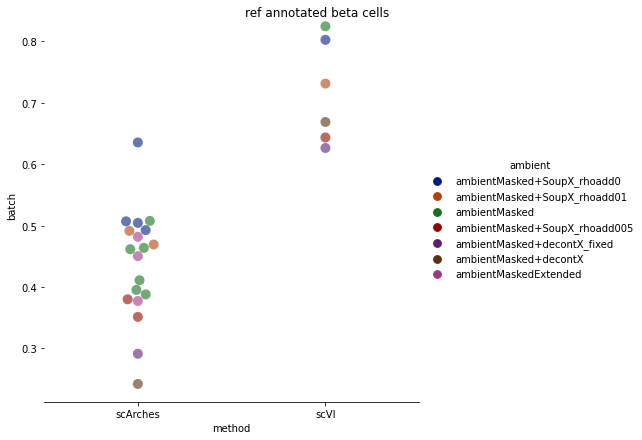

In [22]:
methods=['scVI','scArches']
g = sb.catplot(
    data=rank_beta.query('method in @methods'), 
    x="method", y="batch", hue="ambient", palette="dark", alpha=.6, height=6,s=10,
    kind='swarm'
)
g.despine(left=True)
g.set_axis_labels("method", "batch")
g.fig.suptitle('ref annotated beta cells')

Ranking based on all cells, including non-annotated ones. Note that here a single metric was used in bio score.

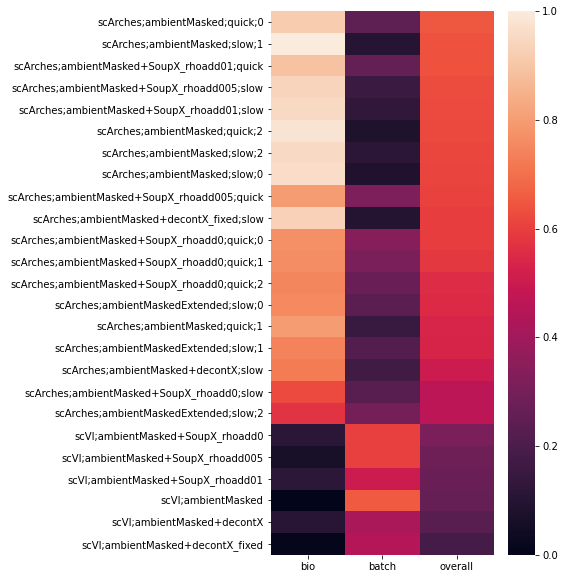

In [13]:
rank_allAll=rank(res_df.query('subset == "all_allCells"'),return_df=True)

In [14]:
rank_allAll['method']=[idx.split(';')[0] for idx in rank_allAll.index]
rank_allAll['ambient']=[idx.split(';')[1] for idx in rank_allAll.index]

Text(0.5, 0.98, 'all cells')

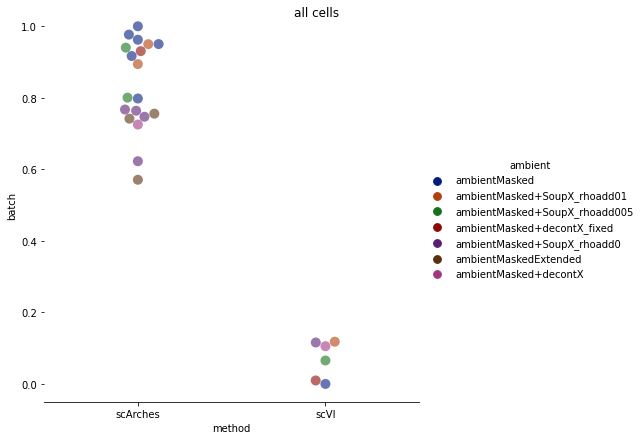

In [15]:
methods=['scVI','scArches']
g = sb.catplot(
    data=rank_allAll.query('method in @methods'), 
    x="method", y="bio", hue="ambient", palette="dark", alpha=.6, height=6,s=10,
    kind='swarm'
)
g.despine(left=True)
g.set_axis_labels("method", "batch")
g.fig.suptitle('all cells')

Text(0.5, 0.98, 'all cells')

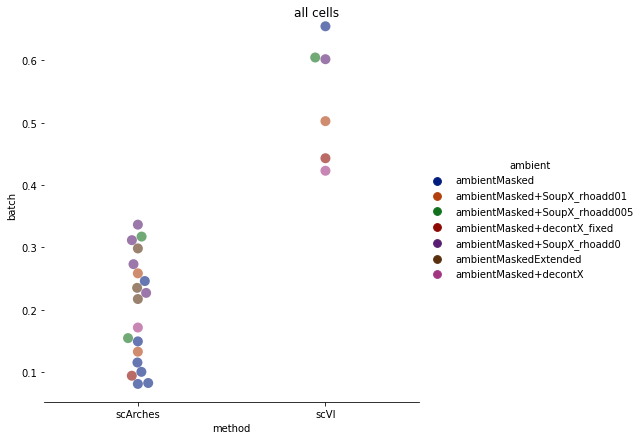

In [16]:
methods=['scVI','scArches']
g = sb.catplot(
    data=rank_allAll.query('method in @methods'), 
    x="method", y="batch", hue="ambient", palette="dark", alpha=.6, height=6,s=10,
    kind='swarm'
)
g.despine(left=True)
g.set_axis_labels("method", "batch")
g.fig.suptitle('all cells')

### Final plot

In [27]:
subset_map={'all':'all annotated',
            'all_allCells':'all',
            'beta':'beta annotated',
           }

In [28]:
# Compute bio and batch scores for all subsets
ranks=[]
for subset in res_df.subset.unique():
    r=rank(res_df.query('subset==@subset'),ignore=['kBET_study'],return_df=True,plot=False)
    r['subset']=subset_map[subset]
    ranks.append(r)
ranks=pd.concat(ranks)
ranks['method']=[idx.split(';')[0] for idx in ranks.index]
ranks['ambient']=[idx.split(';')[1] for idx in ranks.index]
ranks['lr']=[idx.split(';')[2] if len(idx.split(';'))>=3 else 'NA' for idx in ranks.index]

In [29]:
# Palettes
palette={
    'ambientMasked':'#757575', 
    'ambientMaskedExtended':'#000000',
    'ambientMasked+SoupX_rhoadd0':'#e0b002',
    'ambientMasked+SoupX_rhoadd005':'#e07502',
    'ambientMasked+SoupX_rhoadd01':'#b03005', 
    'ambientMasked+decontX':'#45ddf5',
    'ambientMasked+decontX_fixed':'#0a8ec7', 
}
markers={'quick':'x',
        'slow':'o',
        'NA':'v'}

In [30]:
def simple_beeswarm(y, nbins=None):
    # From https://stackoverflow.com/questions/36153410/how-to-create-a-swarm-plot-with-matplotlib
    """
    Returns x coordinates for the points in ``y``, so that plotting ``x`` and
    ``y`` results in a bee swarm plot.
    """
    y = np.asarray(y)
    if nbins is None:
        nbins = len(y) // 4

    # Get upper bounds of bins
    x = np.zeros(len(y))
    ylo = np.min(y)
    yhi = np.max(y)
    dy = (yhi - ylo) / nbins
    ybins = np.linspace(ylo + dy, yhi - dy, nbins - 1)

    # Divide indices into bins
    i = np.arange(len(y))
    ibs = [0] * nbins
    ybs = [0] * nbins
    nmax = 0
    for j, ybin in enumerate(ybins):
        f = y <= ybin
        ibs[j], ybs[j] = i[f], y[f]
        nmax = max(nmax, len(ibs[j]))
        f = ~f
        i, y = i[f], y[f]
    ibs[-1], ybs[-1] = i, y
    nmax = max(nmax, len(ibs[-1]))

    # Assign x indices
    dx = 1 / (nmax // 2)
    for i, y in zip(ibs, ybs):
        if len(i) > 1:
            j = len(i) % 2
            i = i[np.argsort(y)]
            a = i[j::2]
            b = i[j+1::2]
            x[a] = np.arange(1, 1 + len(a)) * dx
            x[b] = np.arange(1, 1 + len(b)) * -dx

    return x
    


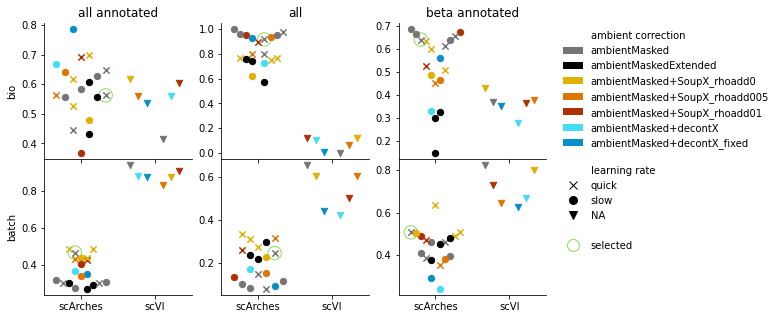

In [32]:
# Plot scatter per subset and bio/batch, marking pp methods, lr, and final selection
# Fig of size bio/batch*subsets
ncol=ranks.subset.nunique()
fig,axs=plt.subplots(2,ncol,figsize=(3*ncol,2.5*2),sharex=True)
plt.subplots_adjust(hspace=0.0)
for idxr,metric in enumerate(['bio','batch']):
    for idxc,subset in enumerate(subset_map.values()):
        ax=axs[idxr,idxc]
        ranks_sub=ranks.query('subset==@subset')
        n_methods=ranks_sub.method.nunique()
        methods={}
        # plot methods (scIV/scarches) into 2 columns
        for idx1,(method,ranks_sub1) in enumerate(ranks_sub.groupby('method')):
            # Compute x of each point - swarm and col position
            ns=ranks_sub1.index
            ys=ranks_sub1[metric]
            xs=simple_beeswarm(ys)
            x_mid=idx1*3
            xs=xs+x_mid
            # Plot each point
            methods[method]=x_mid
            cs=[palette[c] for c in ranks_sub1.ambient]
            ms=[markers[c] for c in ranks_sub1.lr]
            for  x,y,c,m,n in zip(xs,ys,cs,ms,ns):
                ax.scatter(x,y,c=c,marker=m,s=40)
                if n=='scArches;ambientMasked;quick;0':
                     ax.scatter(x,y,marker='o',s=180,
                                facecolors='none', edgecolors='#91db5c')
        # Label columns with method names                
        ax.set_xlim(-1.5,x_mid+1.5)
        ax.set_xticks(list(methods.values()))
        ax.set_xticklabels(labels=list(methods.keys()))
        
        # Titles
        if idxr==0:
            ax.set_title(subset)
        if idxc==0:
            ax.set_ylabel(metric)
        
        # Seethrough
        ax.set(facecolor = (0,0,0,0))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend
        if idxr==0 and idxc==ncol-1:
            legend_elements = [ Patch(alpha=0,label='ambient correction')]+[
                 Patch(facecolor=c,label=s) for s,c in palette.items()
            ]+[ Patch(alpha=0,label='\nlearning rate')]+[
                 Line2D([0],[0],marker=m, color='k',  markerfacecolor='k', 
                        markersize=8,lw=0,label=l) for l,m in markers.items()
            ]+[Line2D([0],[0],marker='o', color='k',  markerfacecolor='none', 
                        markersize=0,markeredgecolor='none',lw=0,label='') 
              ]+[Line2D([0],[0],marker='o', color='k',  markerfacecolor='none', 
                        markersize=12,markeredgecolor='#91db5c',lw=0,label='selected') ]
            ax.legend(handles=legend_elements, bbox_to_anchor=(1.05,1.01),frameon=False)
plt.savefig(path_fig+'swarmplot_atlas_integrationSummary.png',dpi=300,bbox_inches='tight')

## Beta cell integration
Evaluation of integration when using only beta cells (using beta cells that were annotated as such of the all-cells integration (above) re-annotation). Compare to the best integration of all cell types (above) using the same set of cells for evaluation.

In [194]:
# Get all evaluation metric results 
run_dirs=[('combined/scArches/integrate_combine_individual/run_scArches1603792372.695119/beta_integrated/','allCT_scArches;ambientMasked;alpha0.99'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612798260.979096/beta_integrated/','beta_scArches;ambientMasked;alpha0.99'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612875550.182888/beta_integrated/','beta_scArches;ambientMasked;alpha0.9'),
          ('combined/scArches/integrate_combine_individual/run_scArches1612875550.182689/beta_integrated/','beta_scArches;ambientMasked;alpha0.8'),
          ('combined/scArches/integrate_combine_individual/run_scArches1613645086.693854/beta_integrated/','beta_scArches;ambientMasked;alpha0.1'),
          ('combined/scArches/integrate_combine_individual/run_scArches1613645086.693856/beta_integrated/','beta_scArches;ambientMasked;alpha0.2'),
          ('combined/scArches/integrate_combine_individual/run_scArches1613744258.263764/beta_integrated/','beta_scArches;ambientMasked;alpha0.3'),
          ('combined/scArches/integrate_combine_individual/run_scArches1613744258.219381/beta_integrated/','beta_scArches;ambientMasked;alpha0.4'),
          ('combined/scArches/integrate_combine_individual/run_scArches1613645086.694957/beta_integrated/','beta_scArches;ambientMasked;alpha0.5'),
          ('combined/scArches/integrate_combine_individual/run_scArches1613653844.206358/beta_integrated/','beta_scArches;ambientMasked;alpha0.01')
         ]
    


In [195]:
# Store metrics results and corresponding parameters in df
res_df=[]
index=[]
cell_subsets=[('integration_metrics.pkl','annotated'),
             ('integration_metrics_allCells.pkl','allCells')]
for run_dir, run_name in run_dirs:
    for file, subset in cell_subsets:
        if os.path.isfile(runs_path+run_dir+file):
            run_metrics=pickle.load( open(  runs_path+run_dir+file, "rb" ) )
            run_metrics['subset']=subset
            res_df.append(run_metrics)
            index.append(run_name)
res_df=pd.DataFrame(res_df)
res_df.index=index

In [196]:
# Sort runs for plotting
run_datas=[]
for run_name in res_df.index.unique():
    run_datas.append({'run':run_name,
                      'method':run_name.split(';')[0],
                      'alpha':float(run_name.split(';')[2].replace('alpha',''))
                         })
run_datas=pd.DataFrame(run_datas)
run_datas.sort_values(['method','alpha'],inplace=True)
res_df=res_df.loc[run_datas['run'],:]

In [197]:
res_df

,graph_cLISI,NMI,ARI,ASW_cell_type,isolated_label_F1,isolated_label_ASW,moransi_conservation,subset,PC_regression,ASW_batch,kBET,graph_connectivity,graph_iLISI,kBET_study
allCT_scArches;ambientMasked;alpha0.99,0.977793,0.265030,0.164734,0.455087,0.003909,0.540559,0.546797,annotated,NaN,NaN,NaN,NaN,NaN,NaN
allCT_scArches;ambientMasked;alpha0.99,NaN,NaN,NaN,NaN,NaN,NaN,0.560058,allCells,0.585541,0.868362,0.361218,1.0,0.056382,0.232303
beta_scArches;ambientMasked;alpha0.01,0.975389,0.238613,0.104548,0.434345,0.004069,0.486082,0.547371,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.563569,allCells,0.697100,0.858431,0.581477,1.0,0.059764,0.486085
beta_scArches;ambientMasked;alpha0.1,0.976126,0.258034,0.112101,0.440588,0.002319,0.491007,0.548763,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.1,NaN,NaN,NaN,NaN,NaN,NaN,0.564636,allCells,0.701512,0.861020,0.413091,1.0,0.055970,0.330657
beta_scArches;ambientMasked;alpha0.2,0.975755,0.248344,0.160583,0.436470,0.004085,0.486534,0.546205,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.2,NaN,NaN,NaN,NaN,NaN,NaN,0.558768,allCells,0.771359,0.861901,0.413476,1.0,0.071374,0.235602
beta_scArches;ambientMasked;alpha0.3,0.973153,0.203416,0.096657,0.436973,0.003585,0.483093,0.542678,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.3,NaN,NaN,NaN,NaN,NaN,NaN,0.553009,allCells,0.821965,0.858094,0.551218,1.0,0.086829,0.304262


#### On annotated cells with annotated cell subtype
Here we did not claculate batch score on annotated cells as we decided to use the one computed on all cells.

In [28]:
res_df.query('subset == "annotated"')

,graph_cLISI,NMI,ARI,ASW_cell_type,isolated_label_F1,isolated_label_ASW,moransi_conservation,subset,PC_regression,ASW_batch,kBET,graph_connectivity,graph_iLISI,kBET_study
allCT_scArches;ambientMasked;alpha0.99,0.977793,0.265030,0.164734,0.455087,0.003909,0.540559,0.546797,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.01,0.975389,0.238613,0.104548,0.434345,0.004069,0.486082,0.547371,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.1,0.976126,0.258034,0.112101,0.440588,0.002319,0.491007,0.548763,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.2,0.975755,0.248344,0.160583,0.436470,0.004085,0.486534,0.546205,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.3,0.973153,0.203416,0.096657,0.436973,0.003585,0.483093,0.542678,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.4,0.973877,0.219278,0.074423,0.436575,0.002332,0.484729,0.543064,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.5,0.971434,0.170478,0.062278,0.433953,0.002797,0.479513,0.539440,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.8,0.969988,0.147878,0.028394,0.432760,0.004647,0.478638,0.535863,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.9,0.969884,0.147698,0.030885,0.432852,0.006317,0.479801,0.534249,annotated,NaN,NaN,NaN,NaN,NaN,NaN
beta_scArches;ambientMasked;alpha0.99,0.970112,0.151580,0.056855,0.445647,0.001816,0.492476,0.533089,annotated,NaN,NaN,NaN,NaN,NaN,NaN


Scores colored by rank

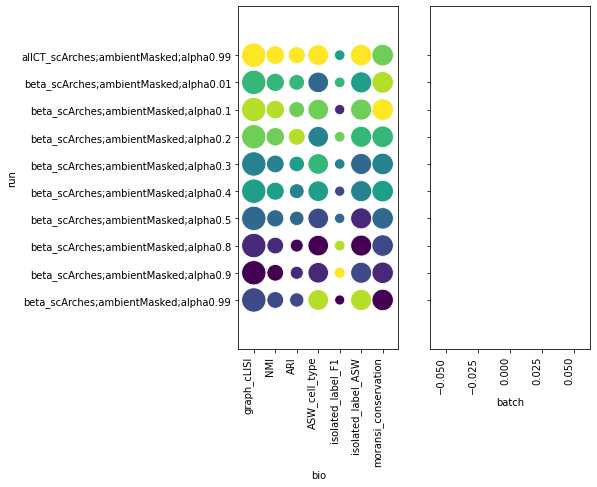

In [29]:
dotplot(res_df.query('subset == "annotated"'),w_scale=0.9,margins=(0.12,0.2))

Scores colored by normalised score across runs

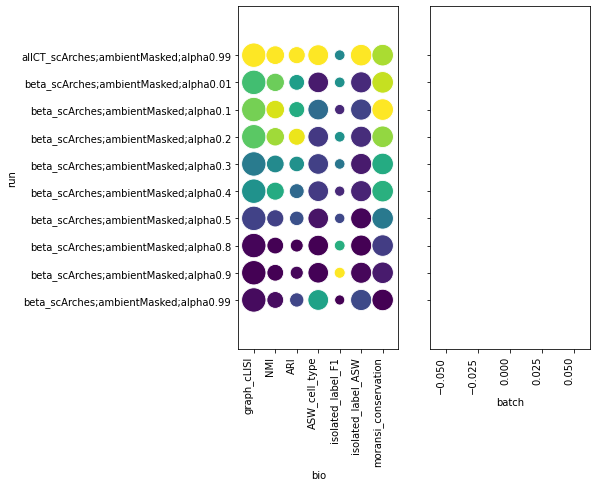

In [30]:
dotplot(res_df.query('subset == "annotated"'),w_scale=0.9,margins=(0.12,0.2),color='normalised')

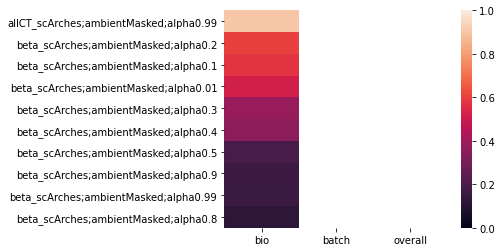

In [34]:
rank_annotated=rank(res_df.query('subset=="annotated"'),return_df=True)

#### On all cells, regardless of subtype annotation

In [31]:
res_df.query('subset == "allCells"')

,graph_cLISI,NMI,ARI,ASW_cell_type,isolated_label_F1,isolated_label_ASW,moransi_conservation,subset,PC_regression,ASW_batch,kBET,graph_connectivity,graph_iLISI,kBET_study
allCT_scArches;ambientMasked;alpha0.99,NaN,NaN,NaN,NaN,NaN,NaN,0.560058,allCells,0.585541,0.868362,0.361218,1.0,0.056382,0.232303
beta_scArches;ambientMasked;alpha0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.563569,allCells,0.697100,0.858431,0.581477,1.0,0.059764,0.486085
beta_scArches;ambientMasked;alpha0.1,NaN,NaN,NaN,NaN,NaN,NaN,0.564636,allCells,0.701512,0.861020,0.413091,1.0,0.055970,0.330657
beta_scArches;ambientMasked;alpha0.2,NaN,NaN,NaN,NaN,NaN,NaN,0.558768,allCells,0.771359,0.861901,0.413476,1.0,0.071374,0.235602
beta_scArches;ambientMasked;alpha0.3,NaN,NaN,NaN,NaN,NaN,NaN,0.553009,allCells,0.821965,0.858094,0.551218,1.0,0.086829,0.304262
beta_scArches;ambientMasked;alpha0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.555269,allCells,0.804097,0.849382,0.514982,1.0,0.082848,0.319925
beta_scArches;ambientMasked;alpha0.5,NaN,NaN,NaN,NaN,NaN,NaN,0.550116,allCells,0.836243,0.865014,0.535501,1.0,0.095996,0.269559
beta_scArches;ambientMasked;alpha0.8,NaN,NaN,NaN,NaN,NaN,NaN,0.544738,allCells,0.857925,0.862758,0.623291,1.0,0.109113,0.262149
beta_scArches;ambientMasked;alpha0.9,NaN,NaN,NaN,NaN,NaN,NaN,0.541978,allCells,0.885596,0.858815,0.642530,1.0,0.117442,0.291946
beta_scArches;ambientMasked;alpha0.99,NaN,NaN,NaN,NaN,NaN,NaN,0.539432,allCells,0.886426,0.851128,0.684932,1.0,0.121204,0.407098


Scores colored by rank

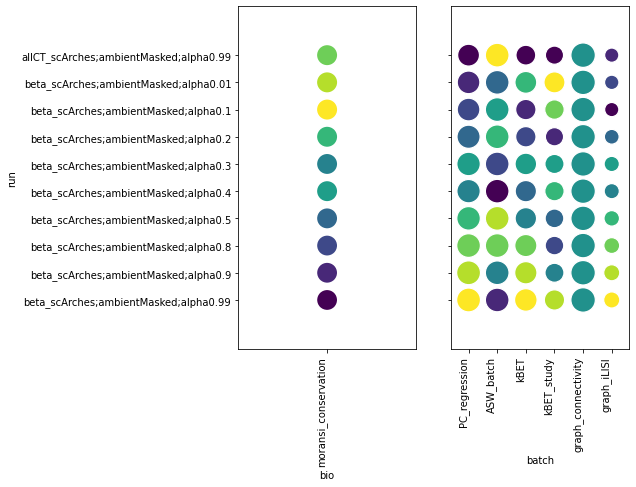

In [32]:
dotplot(res_df.query('subset == "allCells"'),w_scale=1,margins=(0.12,0.2))

Scores colored by normalised score across runs

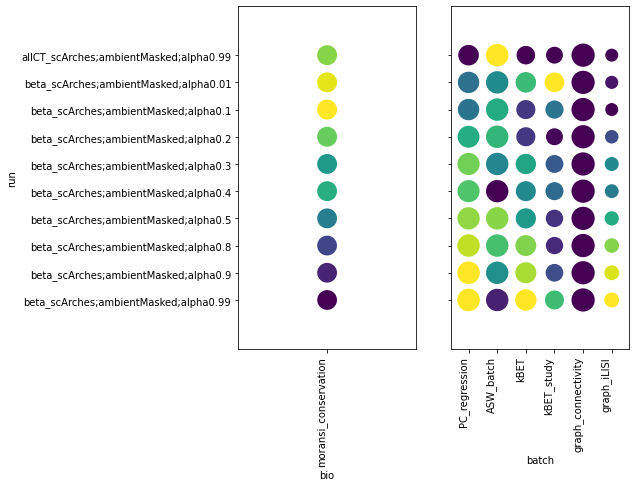

In [33]:
dotplot(res_df.query('subset == "allCells"'),w_scale=1,margins=(0.12,0.2),color='normalised')

In ranking only Moran's I is used for bio preservation as other bio metrics were not computed.

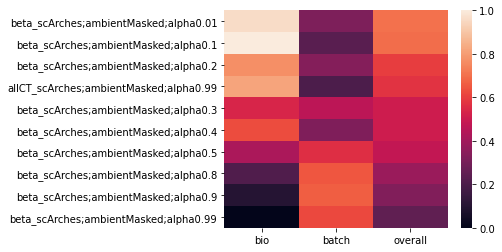

In [35]:
rank_annotated=rank(res_df.query('subset=="allCells"'),return_df=True)

### Final plot
Batch metric comupted on all cells vs bio metric computed on annotated cells.
We decided to use bio metric from annotated cells as it is an average over more individual metrics.

In [199]:
subset_map={'annotated':'annotated subtype',
            'allCells':'all',
           }

In [200]:
# Get score summaries
ranks=[]
for subset in res_df.subset.unique():
    r=rank(res_df.query('subset==@subset'),ignore=['kBET_study'],return_df=True,plot=False)
    r['subset']=subset_map[subset]
    ranks.append(r)
ranks=pd.concat(ranks)
ranks['integrated\ncell types']=[r.split('_')[0].replace('CT','') for r  in ranks.index]

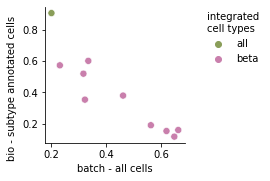

In [231]:
# Bio (compute on annotated cells) vs batch (compute on all cells)
rcParams['figure.figsize']=(2.5,2.5)
g=sb.scatterplot(x=ranks.query('subset=="all"')['batch'].rename('batch - all cells'),
               y=ranks.query('subset=="annotated subtype"')['bio'].rename('bio - subtype annotated cells'),
              hue=ranks.query('subset=="all"')['integrated\ncell types'],s=50,
                palette={'all':'#8a9e59','beta':'#c97fac'})
g.legend(bbox_to_anchor=(1.6,1.03),title='integrated\ncell types',frameon=False)
g.set(facecolor = (0,0,0,0))
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
g.yaxis.set_label_coords(-0.2,0.4)
plt.savefig(path_fig+'scatterplot_beta_integrationSummary.png',dpi=300,bbox_inches='tight')